# Datawhale 气象海洋预测-Task3 模型建立之 CNN+LSTM
本次任务我们将学习来自TOP选手“学习AI的打工人”的建模方案，该方案中采用的模型是CNN+LSTM。

在Task2的数据分析中我们发现，构建新的特征是很困难的，因此本赛题是一个模型问题，我们的主要目标是构造一个能够从小数据集中充分挖掘空间信息和时间信息的模型。那么，说到挖掘空间信息的模型，我们会很自然的想到CNN，同样的，挖掘时间信息的模型我们会很容易想到LSTM，我们本次学习的这个TOP方案正是构造了CNN+LSTM的串行结构。

## 学习目标
1. 学习TOP方案的数据处理方法。
2. 学习TOP方案的模型构建方法。

## 内容介绍
1. 数据处理
    - 增加月特征
    - 数据扁平化
    - 空值填充
    - 构造数据集
2. 模型构建
    - 构造评估函数
    - 模型构造与训练
    - 模型评估
3. 总结

## 代码示例

### 数据处理

该TOP方案的数据处理主要包括四部分：

1. 增加月特征。将序列数据的起始月份作为新的特征。
2. 数据扁平化。将序列数据按月拼接起来通过滑窗增加数据量。
3. 空值填充。
4. 构造数据集。随机采样构造数据集。

在本次任务中我们需要用到TensorFlow Probability（TFP）这个库来计算皮尔逊相关系数，TFP是TensorFlow生态的一部分，它继承了TensorFlow的优势，主要用于概率推理和统计分析。使用方法可以参考TensorFlow Probability指南：https://tensorflow.google.cn/probability/overview?hl=zh-cn

在TensorFlow 1.x中也有计算皮尔逊相关系数的函数tf.contrib.metrics.streaming_pearson_correlation，这里使用的是TensorFlow 2.x，没有相应的函数，因此需要借助TFP这个库，在使用时需要注意与TensorFlow的版本匹配。

In [1]:
# 安装TensorFlow Probability
!pip install tensorflow-probability

In [2]:
import math
import pandas as pd
import numpy as np

import netCDF4 as nc
from netCDF4 import Dataset

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

#忽略警告
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, AveragePooling2D, TimeDistributed, BatchNormalization, Activation, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.regularizers import L2

2021-10-21 08:26:51.500316: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [3]:
# 固定随机种子
SEED = 42

tf.random.set_seed(SEED)
np.random.seed(SEED)

In [4]:
# 读取数据

# 存放数据的路径
path = '/kaggle/input/ninoprediction/'
soda_train = Dataset(path + 'SODA_train.nc')
soda_label = Dataset(path + 'SODA_label.nc')
cmip_train = Dataset(path + 'CMIP_train.nc')
cmip_label = Dataset(path + 'CMIP_label.nc')

#### 增加月特征

本赛题的线上测试集是任意选取某个月为起始的长度为12的序列，因此该方案中增加了起始月份作为新的特征。但是使用整数1~12不能反映12月与1月相邻这一特点，因此需要借助三角函数的周期性，同时考虑到单独使用sin函数或cos函数会存在某些月份的函数值相同的现象，因此同时使用sin函数和cos函数作为两个新增月份特征，保证每个起始月份的这两个特征组合都是独一无二的，并且又能够很好地表现出月份的周期性特征。

我们可以通过可视化直观地感受下每个月份所构造的月份特征组合。

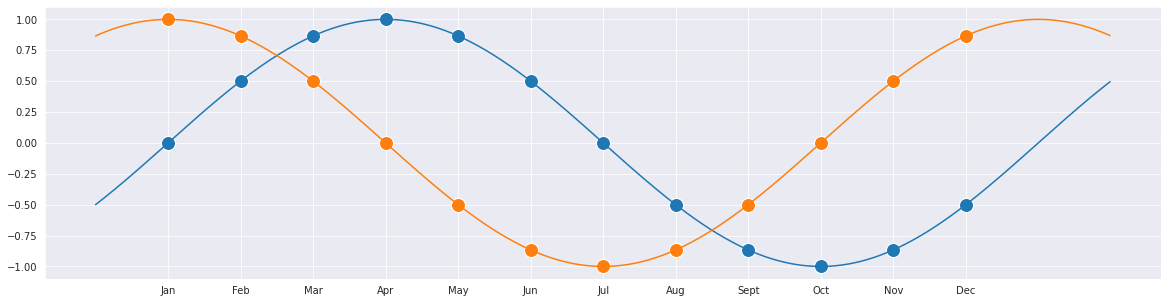

In [5]:
months = range(0, 12)
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
# sin月份特征
months_sin = map(lambda x: math.sin(2 * math.pi * x / len(months)), months)
# cos月份特征
months_cos = map(lambda x: math.cos(2 * math.pi * x / len(months)), months)

# 绘制每个月的月份特征组合
plt.figure(figsize=(20, 5))
x_axis = np.arange(-1, 13, 1e-2)
sns.lineplot(x=x_axis, y=np.sin(2 * math.pi * x_axis / len(months)))
sns.lineplot(x=x_axis, y=np.cos(2 * math.pi * x_axis / len(months)))
sns.scatterplot(x=months, y=months_sin, s=200)
sns.scatterplot(x=months, y=months_cos, s=200)
plt.xticks(ticks=months, labels=month_labels)
plt.show()

构造SODA数据的sin月份特征。

In [6]:
# 构造一个维度为100*36*24*72的矩阵，矩阵中的每个值为所在月份的sin函数值
soda_month_sin = np.zeros((100, 36, 24, 72))
for y in range(100):
    for m in range(36):
        for lat in range(24):
            for lon in range(72):
                soda_month_sin[y, m, lat, lon] = math.sin(2 * math.pi * (m % 12) / 12)
                
soda_month_sin.shape

(100, 36, 24, 72)

构造SODA数据的cos月份特征。

In [7]:
# 构造一个维度为100*36*24*72的矩阵，矩阵中的每个值为所在月份的cos函数值
soda_month_cos = np.zeros((100, 36, 24, 72))
for y in range(100):
    for m in range(36):
        for lat in range(24):
            for lon in range(72):
                soda_month_cos[y, m, lat, lon] = math.cos(2 * math.pi * (m % 12) / 12)
                
soda_month_cos.shape

(100, 36, 24, 72)

构造CMIP数据的sin月份特征。

In [8]:
# 构造一个维度为4645*36*24*72的矩阵，矩阵中的每个值为所在月份的sin函数值
cmip_month_sin = np.zeros((4645, 36, 24, 72))
for y in range(4645):
    for m in range(36):
        for lat in range(24):
            for lon in range(72):
                cmip_month_sin[y, m, lat, lon] = math.sin(2 * math.pi * (m % 12) / 12)
                
cmip_month_sin.shape

(4645, 36, 24, 72)

构造CMIP数据的cos月份特征。

In [9]:
# 构造一个维度为4645*36*24*72的矩阵，矩阵中的每个值为所在月份的cos函数值
cmip_month_cos = np.zeros((4645, 36, 24, 72))
for y in range(4645):
    for m in range(36):
        for lat in range(24):
            for lon in range(72):
                cmip_month_cos[y, m, lat, lon] = math.cos(2 * math.pi * (m % 12) / 12)
                
cmip_month_cos.shape

(4645, 36, 24, 72)

#### 数据扁平化

在Task2中我们发现，赛题中给出的数据量非常少，如何增加数据量呢？对于时序数据，一种常用的做法就是滑窗。

由于每条数据在时间上有重叠，我们取数据的前12个月拼接起来，就得到了长度为（数据条数×12个月）的序列数据，如图1所示：
<img src="Task3-图1.jpg" width="70%">

然后我们以每个月为起始月，接下来的12个月作为模型输入X，后24个月的Nino3.4指数作为预测目标Y构建训练样本，如图2所示：
<img src="Task3-图2.jpg" width="70%">

需要注意的是，CMIP数据提供了不同的拟合模式，只有在同种模式下各个年份的数据在时间上是连续的，因此同种模式的数据才能在时间上拼接起来，除去最后11个月不能构成训练样本外，滑窗最终能获得的训练样本数量可以按以下方式计算得到：

- SODA：1种模式×（100年×12-11）=1189条样本
- CMIP6：15种模式×（151年×12-11）=27015条样本
- CMIP5：17种模式×（140年×12-11）=28373条样本

在下面的代码中，我们只将各个模式的数据拼接起来而没有采用滑窗，这是因为考虑到采用滑窗得到的训练样本维度是（数据条数×12×24×72），需要占用大量的内存资源。我们在之后构建数据集时，随机抽取了部分样本，大家在实际问题中，如果资源足够的话，可以采用滑窗构建的全部的数据，不过需要注意数据量大的情况下可以考虑构建更深的模型来挖掘更多信息。

In [10]:
def make_flatted(train_ds, label_ds, month_sin, month_cos, info, start_idx=0):
    keys = ['sst', 't300', 'ua', 'va']
    label_key = 'nino'
    # 年数
    years = info[1]
    # 模式数
    models = info[2]
    
    train_list = []
    label_list = []
    
    # 将同种模式下的数据拼接起来
    for model_i in range(models):
        blocks = []
        
        # 对每个特征，取每条数据的前12个月进行拼接
        for key in keys:
            block = train_ds[key][start_idx + model_i * years: start_idx + (model_i + 1) * years, :12].reshape(-1, 24, 72, 1).data
            blocks.append(block)
        # 增加sin月份特征
        block_sin = month_sin[start_idx + model_i * years: start_idx + (model_i + 1) * years, :12].reshape(-1, 24, 72, 1)
        blocks.append(block_sin)
        # 增加cos月份特征
        block_cos = month_cos[start_idx + model_i * years: start_idx + (model_i + 1) * years, :12].reshape(-1, 24, 72, 1)
        blocks.append(block_cos)
        
        # 将所有特征在最后一个维度上拼接起来
        train_flatted = np.concatenate(blocks, axis=-1)
        
        # 取12-23月的标签进行拼接，注意加上最后一年的最后12个月的标签（与最后一年12-23月的标签共同构成最后一年前12个月的预测目标）
        label_flatted = np.concatenate([
            label_ds[label_key][start_idx + model_i * years: start_idx + (model_i + 1) * years, 12: 24].reshape(-1).data,
            label_ds[label_key][start_idx + (model_i + 1) * years - 1, 24: 36].reshape(-1).data
        ], axis=0)
        
        train_list.append(train_flatted)
        label_list.append(label_flatted)
        
    return train_list, label_list

In [11]:
soda_info = ('soda', 100, 1)
cmip6_info = ('cmip6', 151, 15)
cmip5_info = ('cmip5', 140, 17)

soda_trains, soda_labels = make_flatted(soda_train, soda_label, soda_month_sin, soda_month_cos, soda_info)
cmip6_trains, cmip6_labels = make_flatted(cmip_train, cmip_label, cmip_month_sin, cmip_month_cos, cmip6_info)
cmip5_trains, cmip5_labels = make_flatted(cmip_train, cmip_label, cmip_month_sin, cmip_month_cos, cmip5_info, cmip6_info[1]*cmip6_info[2])

# 得到扁平化后的数据维度为（模式数×序列长度×纬度×经度×特征数），其中序列长度=年数×12
np.shape(soda_trains), np.shape(cmip6_trains), np.shape(cmip5_trains)

((1, 1200, 24, 72, 6), (15, 1812, 24, 72, 6), (17, 1680, 24, 72, 6))

#### 空值填充

在Task2中我们发现，除SST外，其它特征中都存在空值，这些空值基本都在陆地上，因此我们直接将空值填充为0。

In [13]:
# 填充SODA数据中的空值
soda_trains = np.array(soda_trains)
soda_trains_nan = np.isnan(soda_trains)
soda_trains[soda_trains_nan] = 0
print('Number of null in soda_trains after fillna:', np.sum(np.isnan(soda_trains)))

Number of null in soda_trains after fillna: 0


In [14]:
# 填充CMIP6数据中的空值
cmip6_trains = np.array(cmip6_trains)
cmip6_trains_nan = np.isnan(cmip6_trains)
cmip6_trains[cmip6_trains_nan] = 0
print('Number of null in cmip6_trains after fillna:', np.sum(np.isnan(cmip6_trains)))

Number of null in cmip6_trains after fillna: 0


In [15]:
# 填充CMIP5数据中的空值
cmip5_trains = np.array(cmip5_trains)
cmip5_trains_nan = np.isnan(cmip5_trains)
cmip5_trains[cmip5_trains_nan] = 0
print('Number of null in cmip6_trains after fillna:', np.sum(np.isnan(cmip5_trains)))

Number of null in cmip6_trains after fillna: 0


#### 构造数据集

在划分训练/验证集时，一个需要考虑的问题是训练集、验证集、测试集三者的分布是否是一致的。在本赛题中我们拿到的是两份数据，其中CMIP数据是CMIP5/6模式模拟的历史数据，SODA数据是由SODA模式重建的的历史观测同化数据，线上测试集则是来自国际多个海洋资料的同化数据，由此看来，SODA数据和线上测试集的分布是较为一致的，CMIP数据的分布则与测试集不同。在三者不一致的情况下，我们通常会尽可能使验证集与测试集的分布一致，这样当模型在验证集上有较好的表现时，在测试集上也会有较好的表现。

因此，我们从CMIP数据的每个模式中各抽取100条数据作为训练集（这里抽取的样本数只是作为一个示例，实际模型训练的时候使用多少样本需要综合考虑可用的资源条件和构建的模型深度），从SODA模式中抽取100条数据作为验证集。有的同学可能会疑惑，既然这里只用了100条SODA数据，那么为什么还要对SODA数据扁平化后再抽样而不直接用原始数据呢，因为直接取原始数据的前12个月作为输入，后24个月作为标签所得到的验证集每一条都是从0月开始的，而线上的测试集起始月份是随机抽取的，因此这里仍然要尽可能保证验证集与测试集的数据分布一致，使构建的验证集的起始月份也是随机的。

我们这里没有构造测试集，因为线上的测试集已经公开了，可以直接使用，在比赛时，线上的测试集是保密的，需要构造线下的测试集来评估模型效果，同时需要注意线下的评估结果和线上的提交结果是否差距不大或者变化趋势是一致的，如果不是就需要调整线下的测试集，保证它和线上测试集的分布尽可能一致，能够较为准确地指示模型的调整方向。

In [16]:
# 构造训练集

X_train = []
y_train = []
# 从CMIP5的17种模式中各抽取100条数据
for model_i in range(17):
    samples = np.random.choice(cmip5_trains.shape[1]-12, size=100)
    for ind in samples:
        X_train.append(cmip5_trains[model_i, ind: ind+12])
        y_train.append(cmip5_labels[model_i][ind: ind+24])
# 从CMIP6的15种模式种各抽取100条数据
for model_i in range(15):
    samples = np.random.choice(cmip6_trains.shape[1]-12, size=100)
    for ind in samples:
        X_train.append(cmip6_trains[model_i, ind: ind+12])
        y_train.append(cmip6_labels[model_i][ind: ind+24])
X_train = np.array(X_train)
y_train = np.array(y_train)

In [17]:
# 构造测试集

X_valid = []
y_valid = []
samples = np.random.choice(soda_trains.shape[1]-12, size=100)
for ind in samples:
    X_valid.append(soda_trains[0, ind: ind+12])
    y_valid.append(soda_labels[0][ind: ind+24])
X_valid = np.array(X_valid)
y_valid = np.array(y_valid)

In [18]:
# 查看数据集维度
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((3200, 12, 24, 72, 6), (3200, 24), (100, 12, 24, 72, 6), (100, 24))

In [20]:
# 保存数据集
np.save('X_train_sample.npy', X_train)
np.save('y_train_sample.npy', y_train)
np.save('X_valid_sample.npy', X_valid)
np.save('y_valid_sample.npy', y_valid)

### 模型构建

在模型构建部分的通用流程是：构造评估函数 -> 构建并训练模型 -> 模型评估，后两步是循环的，可以根据评估结果重新调整并训练模型，再重新进行评估。

#### 构造评估函数

模型的评估函数通常就是官方给出的评估指标，不过在比赛中经常会出现线下的评估结果和提交后的线上评估结果不一致的情况，这通常是线下测试集和线上测试集不一致造成的。

In [21]:
# 读取数据集
X_train = np.load('../input/ai-earth-task03-samples/X_train_sample.npy')
y_train = np.load('../input/ai-earth-task03-samples/y_train_sample.npy')
X_valid = np.load('../input/ai-earth-task03-samples/X_valid_sample.npy')
y_valid = np.load('../input/ai-earth-task03-samples/y_valid_sample.npy')

In [22]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((3200, 12, 24, 72, 6), (3200, 24), (100, 12, 24, 72, 6), (100, 24))

In [23]:
def rmse(y_true, y_preds):
    return np.sqrt(mean_squared_error(y_pred = y_preds, y_true = y_true))

# 评估函数
def score(y_true, y_preds):
    # 相关性技巧评分
    accskill_score = 0
    # RMSE
    rmse_scores = 0
    a = [1.5] * 4 + [2] * 7 + [3] * 7 + [4] * 6
    y_true_mean = np.mean(y_true, axis=0)
    y_pred_mean = np.mean(y_preds, axis=0)
    for i in range(24):
        fenzi = np.sum((y_true[:, i] - y_true_mean[i]) * (y_preds[:, i] - y_pred_mean[i]))
        fenmu = np.sqrt(np.sum((y_true[:, i] - y_true_mean[i])**2) * np.sum((y_preds[:, i] - y_pred_mean[i])**2))
        cor_i = fenzi / fenmu
        accskill_score += a[i] * np.log(i+1) * cor_i
        rmse_score = rmse(y_true[:, i], y_preds[:, i])
        rmse_scores += rmse_score
    return 2/3.0 * accskill_score - rmse_scores

#### 模型构造与训练

这部分是赛题的重点，该TOP方案采用的是CNN+LSTM的串行结构，其中CNN用来提取空间信息，LSTM用来提取时间信息。

- CNN部分

CNN常用于处理图像信息，它在处理空间信息上也有很好的表现。CNN的输入尺寸是（Batch，H，W，C），其中Batch是批量梯度下降中一个批次的样本数量，H和W分别是输入图像的高和宽，C是输入图像的通道数，对于本题中的空间数据，H和W就对应数据的纬度和经度，C对应特征数。我们的训练样本中还多了一个时间维度，因此需要用TimeDistributed来包装卷积层。

TimeDistributed是一个层封装器，它的参数是一个神经网络层，它的作用是将这个网络层应用到输入的每一个时间步上。例如，我们的每个输入样本的维度是（12，24，72，6），用TimeDistributed包装卷积层Conv2D，它就会将卷积层应用于这12个时间步的每一个，而卷积层作用的输入维度就是（24，72，6）。说明文档可以参考https://keras.io/zh/layers/wrappers/

BatchNormalization（后面简称BN）是批标准化层，通常放在卷积层后用于标准化数据的分布，能够减少各层不同数据分布之间的相互影响和依赖，具有加快模型训练速度、避免梯度爆炸、在一定程度上能增强模型泛化能力等优点，是神经网络问题中常用的“大杀器”。不过目前关于BN层和ReLU激活函数的放置顺序孰先孰后的问题众说纷纭，具体还是看模型的效果。关于这个问题的讨论可以参考https://www.zhihu.com/question/283715823

总体来看CNN这一部分采用的是比较通用的结构，第一层采用比较大的卷积核（7×7），后面接多层的小卷积核（3×3），并用BN提升模型效果，用池化层减少模型参数，池化层常用的有MaxPooling和AveragePooling，通常MaxPooling效果更好，不过具体看模型效果。模型的主要难点就在于调参，目前模型调参没有标准的答案，更多地是参考前人的经验以及不断地尝试。

- LSTM部分

CNN部分经过Flatten层将除时间维度以外的维度压平（即除时间步长12外的其它维度大小相乘，例如CNN部分最后的池化层输出维度是（T，H，W，C），则压平后的维度是（T，H×W×C）），输入LSTM层。LSTM层接受的输入维度为（Time_steps，Input_size），其中Time_steps就是时间步长12，Input_size是压平后的维度大小。keras中LSTM的主要参数是units（输出维度）、activation（激活函数）、return_sequences（是否返回最后一个输出），return_sequences为True时返回的是全部的时间序列，即维度是（Time_steps，units），为False时只返回最后一个时间步的输出，即维度（units）。LSTM的使用方法可以参考https://keras.io/zh/layers/recurrent/

LSTM的参数量是4倍的Input_size×units，参数量过多就容易过拟合，同时我们之间构建的训练样本也不够多，因此该方案中只堆叠了两个LSTM层。

In [24]:
# 模型构造
def build_model(learning_rate, reg_lambda = 0.001):    
    # 定义模型输入
    inp = tf.keras.layers.Input(shape=(12, 24, 72, 6))

    # CNN部分
    x = TimeDistributed(Conv2D(32, (7, 7), strides=(2, 2), padding='same', kernel_regularizer=L2(reg_lambda)))(inp)
    x = TimeDistributed(BatchNormalization())(x)
    x = TimeDistributed(Activation('relu'))(x)
    x = TimeDistributed(Conv2D(32, (3, 3), padding='same', kernel_regularizer=L2(reg_lambda)))(x)
    x = TimeDistributed(BatchNormalization())(x)
    x = TimeDistributed(Activation('relu'))(x)
    x = TimeDistributed(AveragePooling2D((2, 2), strides=(2, 2)))(x)
    x = TimeDistributed(Flatten())(x)

    # LSTM部分
    x = LSTM(2048, return_sequences=True, dropout=0.5)(x)
    x = LSTM(1024, return_sequences=False)(x)

    # 模型输出
    out = Dense(24, activation='linear')(x)
    # 建立模型
    model = Model(inputs=inp, outputs=out)
    # 使用RMSprop作为模型优化器
    opt = tf.optimizers.RMSprop(lr=learning_rate)
    # 模型编译，损失函数是MSE，赛题的评估指标中包括相关系数，因此用皮尔逊相关系数作为评价指标
    model.compile(optimizer = opt, loss = 'mean_squared_error', metrics=[tfp.stats.correlation])

    return model

In [25]:
learning_rate = 3e-4
model = build_model(learning_rate)
model.summary()

2021-10-21 08:36:45.169856: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-21 08:36:45.188233: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-10-21 08:36:45.232270: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-21 08:36:45.232902: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-10-21 08:36:45.232956: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-10-21 08:36:45.257289: I tensorflow/stream_executor/platform/def

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 12, 24, 72, 6)]   0         
_________________________________________________________________
time_distributed (TimeDistri (None, 12, 12, 36, 32)    9440      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 12, 12, 36, 32)    128       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 12, 12, 36, 32)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 12, 12, 36, 32)    9248      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 12, 12, 36, 32)    128       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 12, 12, 36, 32)    0     

在模型训练时，有一些常用的回调函数：

- ModelCheckPoint：在每个训练周期后保存模型，其中参数monitor为模型的监测指标，save_best_only设为True时监测指标最优的模型不会被覆盖，mode用来定义监测指标为最大或最小时模型最优。

- EarlyStopping：早停，当监测指标在设定的训练轮数内不再提升时停止训练，其中参数patience为可容忍的指标不提升的训练轮数。

- ReduceLROnPlateau：当监测指标在设定的训练轮数内不提升时降低学习率，其中参数factor为学习率降低的因数，新的学习率=factor×学习率。

也可以通过扩展keras.callbacks.Callback子类自定义回调函数，回调函数的详细说明文档参考https://keras.io/zh/callbacks/

In [26]:
# 模型权重的保存路径
model_weights = './cnn_lstm_baseline.h5'
# 设置回调函数
checkpoint = ModelCheckpoint(model_weights, monitor='val_loss', verbose=0, save_best_only=True, mode='min',
                             save_weights_only=True)
early_stopping = EarlyStopping(monitor="val_loss", patience=5)
# 训练模型并保存训练历史
history = model.fit(X_train, y_train,
                    validation_data=(X_valid, y_valid),
                    batch_size=256, epochs=100,
                    callbacks=[checkpoint, early_stopping],
                    verbose=2)

2021-10-21 08:36:57.784602: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1592524800 exceeds 10% of free system memory.
2021-10-21 08:36:59.036796: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-10-21 08:36:59.047003: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000175000 Hz


Epoch 1/100


2021-10-21 08:37:02.406166: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-10-21 08:37:03.215041: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-10-21 08:37:03.263644: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


13/13 - 14s - loss: 1.3441 - correlation: 0.1157 - val_loss: 0.6378 - val_correlation: 0.0037
Epoch 2/100
13/13 - 3s - loss: 0.7360 - correlation: 0.3312 - val_loss: 0.6181 - val_correlation: -2.5095e-02
Epoch 3/100
13/13 - 3s - loss: 0.6452 - correlation: 0.3593 - val_loss: 0.6477 - val_correlation: 0.0056
Epoch 4/100
13/13 - 3s - loss: 0.6014 - correlation: 0.3569 - val_loss: 0.5507 - val_correlation: 0.0564
Epoch 5/100
13/13 - 3s - loss: 0.5556 - correlation: 0.3744 - val_loss: 0.7436 - val_correlation: 0.0612
Epoch 6/100
13/13 - 3s - loss: 0.5406 - correlation: 0.3820 - val_loss: 0.5429 - val_correlation: 0.0884
Epoch 7/100
13/13 - 3s - loss: 0.5221 - correlation: 0.3952 - val_loss: 0.5681 - val_correlation: 0.0911
Epoch 8/100
13/13 - 3s - loss: 0.5108 - correlation: 0.3954 - val_loss: 0.5944 - val_correlation: 0.0773
Epoch 9/100
13/13 - 3s - loss: 0.5015 - correlation: 0.3890 - val_loss: 0.5569 - val_correlation: 0.0708
Epoch 10/100
13/13 - 3s - loss: 0.4667 - correlation: 0.4111 

In [27]:
# 查看训练历史中保存的监测指标
history.history.keys()

dict_keys(['loss', 'correlation', 'val_loss', 'val_correlation'])

In [28]:
# 绘制训练/验证曲线
def training_vis(hist):
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    corr = hist.history['correlation']
    val_corr = hist.history['val_correlation']
    
    # 绘制损失函数曲线
    fig = plt.figure(figsize=(8,4))
    # subplot loss
    ax1 = fig.add_subplot(121)
    ax1.plot(loss,label='train_loss')
    ax1.plot(val_loss,label='val_loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss on Training and Validation Data')
    ax1.legend()
    # 绘制皮尔逊相关系数曲线
    ax2 = fig.add_subplot(122)
    ax2.plot(corr,label='train_pearson_correction')
    ax2.plot(val_corr,label='val_pearson_correction')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Pearson Correction')
    ax2.set_title('Pearson Correction on Training and Validation Data')
    ax2.legend()
    plt.tight_layout()

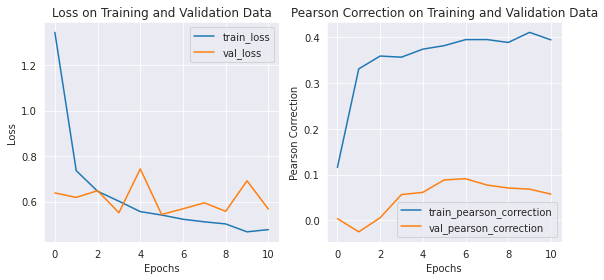

In [29]:
training_vis(history)

我们通常会绘制训练/验证曲线来观察模型的拟合情况，上图中我们分别绘制了训练过程中训练集和验证集损失函数变化曲线及皮尔逊相关系数变化曲线。可以看到，训练集的损失函数下降很快，但是验证集的损失函数是震荡的，没有明显的下降，这说明模型的学习效果较差，并存在过拟合问题，需要调整相关的参数。

#### 模型评估

最后，我们在测试集上评估模型的训练结果。

In [30]:
# 测试集路径
test_path = '../input/ai-earth-tests/'
# 测试集标签路径
test_label_path = '../input/ai-earth-tests-labels/'

In [31]:
import os

# 读取测试数据和测试数据的标签，并记录每个测试样本的起始月份用于之后构造月份特征
files = os.listdir(test_path)
X_test = []
y_test = []
first_months = []  # 样本起始月份
for file in files:
    X_test.append(np.load(test_path + file))
    y_test.append(np.load(test_label_path + file))
    first_months.append(int(file.split('_')[2]))

In [32]:
X_test = np.array(X_test)
y_test = np.array(y_test)
X_test.shape, y_test.shape

((103, 12, 24, 72, 4), (103, 24))

In [33]:
# 构造一个维度为103*12*24*72的矩阵，矩阵中的每个值为所在月份的sin函数值
test_month_sin = np.zeros((103, 12, 24, 72, 1))
for y in range(103):
    for m in range(12):
        for lat in range(24):
            for lon in range(72):
                test_month_sin[y, m, lat, lon] = math.sin(2 * math.pi * ((m + first_months[y]-1) % 12) / 12)
                
test_month_sin.shape

(103, 12, 24, 72, 1)

In [34]:
# 构造一个维度为103*12*24*72的矩阵，矩阵中的每个值为所在月份的cos函数值
test_month_cos = np.zeros((103, 12, 24, 72, 1))
for y in range(103):
    for m in range(12):
        for lat in range(24):
            for lon in range(72):
                test_month_cos[y, m, lat, lon] = math.cos(2 * math.pi * ((m + first_months[y]-1) % 12) / 12)
                
test_month_cos.shape

(103, 12, 24, 72, 1)

In [35]:
# 构造测试集
X_test = np.concatenate([X_test, test_month_sin, test_month_cos], axis=-1)
X_test.shape

(103, 12, 24, 72, 6)

In [36]:
# 模型预测
test_preds = model.predict(X_test)

In [37]:
# 模型评估
score = score(y_test, test_preds)
print(score)

22.950661372376207


## 总结

- 该方案在数据处理部分增加了一组月份特征，个人认为在使用了时序模型的情况下增加的这组特征收益不高，并且由于维度增加会使得训练数据占用内存大大增加，在本赛题中对模型的效果提升不明显。不过在其他场景中这种特征构造方法仍然是值得借鉴的。
- 该方案构造模型的思路非常适合初学者学习，灵活地将不同模型串行结合能够结合模型各自的优势，这种模型构造方法需要注意的是一个模型的输出维度与另一个模型接受的输入维度要相互匹配。

## 参考文献
1. “学习AI的打工人”经验分享：https://tianchi.aliyun.com/notebook-ai/detail?spm=5176.12586969.1002.18.561d5330HKwYOW&postId=196536